In [1]:
%%capture
%reload_ext autoreload
%autoreload 2
%cd ..

In [116]:
from src.taa.tools.data import get_strategy_price_data
from src.taa.strategy.static import STRATEGIES
from src.taa.strategy.strategies import StrategyPipeline
from src.taa.strategy.signals import Signal
from src.taa.backtest.positions import EqualWeights, RiskParity
from src.taa.backtest.performance import Tearsheet
from src.taa.backtest.returns import Backtester

import pandas as pd
import numpy as np

In [216]:
start, end = "2011-01-01", "2023-03-01"
rebalance_dates = pd.bdate_range(start, end, freq="BM")

pipeline = StrategyPipeline(STRATEGIES)
data = get_strategy_price_data(pipeline, start, end).dropna()

In [238]:
# ivy
strategy = pipeline.ivy
strategy_data = data[strategy.risk_assets]
signals = Signal(strategy_data).sma_crossover(10).dropna()

weights = signals.apply(lambda x: np.where(x > 0, strategy.weights[0], 0))
weights.loc[:, strategy.safe_assets] = 1 - weights.sum(axis=1)
weights.columns.name = "ID"
weights = weights.stack().rename(strategy.tag).to_frame()

# benchmark strategies
assets = strategy.get_tickers()
returns = data.pct_change().dropna().loc[:, assets]

ew = EqualWeights(assets, rebalance_dates).weights
# somethings wrong with the inverse vol date look up in risk parity...
# rp = RiskParity(assets, rebalance_dates, returns)

In [241]:
bt = Backtester(weights.merge(ew, on=["Date", "ID"]), "USD")
port_returns = bt.run()

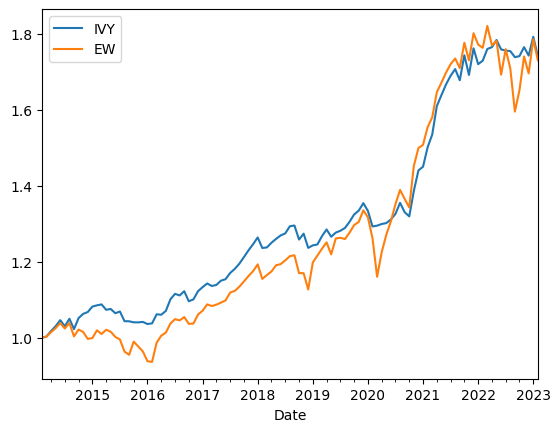

In [243]:
port_returns.add(1).cumprod().plot();

In [244]:
Tearsheet(port_returns).summary()

,IVY,EW
#obs,109.000000,109.000000
#years,13.043651,13.043651
Total Return,0.740531,0.730045
Annual. Return,0.043403,0.042920
Volatility,0.258106,0.415157
MaxDD,-0.047377,-0.130983
Skewness,-0.007746,-0.227030
Kurtosis,3.673587,4.060427
Sharpe Ratio,5.103930,3.265820
StdErr,0.286625,0.287627
